# DSCI 100 Project Final Report

## Introduction

&nbsp; A research team at UBC wants to collect data about how people play video games. To do this, they plan to recruit participants to play Minecraft on a recorded server, which will allow them to observe player actions and interactions. They wish to target their recruitment efforts to maximize the amount of data they can collect. 
<br>
<br>
&nbsp; We utilized data collected by the research team to identify which kinds of players are most likely to contribute large amounts of data so that those players can be targeted in recruiting efforts. Specifically, we aimed to determine whether or not we can estimate the total playing time a participant will contribute based on their age and experience. The research team provided 2 datasets: players.csv and sessions.csv, which we will refer to as the Players Dataset and the Sessions Dataset. The Players Dataset contains 196 observations and the following 9 variables: experience, subscribe, hashedEmail, played_hours, name, gender, age, individualID, and organizationName. The Sessions Dataset contains 1535 observations and the following 5 variables: hashedEmail, start_time, end_time, original_start_time, and original_end_time. All variables and potential issues with the data are described in the tables below. We only looked at the experience, age, and played_hours variables in the Players Dataset to address our question. 
<br>
<br>

##### **Table 1: Variable Descriptions**

| Variable Name | Variable Type | Meaning |
|---------------|---------------|---------|
|experience|character|players experience level|
|subscribe|logical|whether or not player is subscribed to email updates|
|hashedEmail|character|players encrypted email address|
|played_hours|double|total hours of play time contributed|
|name|character|players name|
|gender|character|players gender|
|age|double|players age|
|individualID|logical|assumed to be a string of numbers and/or letters assigned to player for identification|
|organizationName|logical|assumed to be name of the group that was asked to participate which player is part of|
|start_time|character|start date and time of playing session|
|end_time|character|end date and time of playing session|
|original_start_time|double|start time of playing session in unix timestamp format|
|original_end_time|double|end time of playing session in unix timestamp format|
<br>
<br>

##### **Table 2: Issues with Data**

| Data Table | Issue |
|------------|-------|
|Players Dataset|individualID and organizationName columns provide no information|
|Players Dataset|experience and gender should be factors because they are categorical|
|Players Dataset|some variables don’t contain equal amounts of each type (eg. there are more males than any other gender, etc.)|
|Sessions Dataset|multiple observations with the same hashedEmail, may affect whether/how observations are grouped later on for analysis|
|Sessions Dataset|start_time and end_time columns should be datetime, not character|
|Sessions Dataset|all observations for original_start_time and original_end_time are the same because they are in unix timestamp format and the values are too large, are not providing valuable information|
|Both|data is in 2 data frames, should be in 1|
|Both|sessions data has more observations than players data, may be an issue when merging data sets if one has more unique hashed emails than the other|

## Methods and Results

&nbsp; We used the played_hours, experience, and age columns from the Players Data dataset to train and create a KNN and linear regression model with played_hours as the response variable. We chose regression models over a classification model because we want to predict a numerical variable (total play time contributed) as opposed to a class. We decided to initially model both KNN and linear regression and later determine whether one model is more appropriate for answering our question than another by comparing their RMSPE values and favouring the model with the lower RMSPE. To further support our decision, we plan to plot the data to help visualize any apparent trends. This will help us consider the linearity of the data to determine whether linear regression or knn regression will be a better fit.   

&nbsp; We began by loading in the tidyverse, tidymodels, and dplr libraries and reading in the Players Dataset using the provided url. The data was then cleaned and wrangled to ensure that it was in proper format for usage. We selected the played_hours, experience, and age columns from the dataset and mutated the experience observations from character to numerical elements. Experience observations were altered to be represented by numerical levels where Pro=5, Veteran=4, Regular=3, Beginner=2, and Amateur=1. 

In [1]:
library(tidyverse)
library(tidymodels)
library(dplyr)
install.packages("plotly")
library(plotly)
url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
data <- read_csv(url)
head(data)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


In [2]:
#selecting columns and changing experience levels to numerical values
full_unedited <- data |>
                select(experience, played_hours, age) |>
                mutate(experience = recode(experience,
                            Pro = "5",
                            Veteran = '4',
                            Regular = '3',
                            Beginner = '2',
                            Amateur = '1'), 
                            experience = as.numeric(experience))
  
head(full_unedited)

experience,played_hours,age
<dbl>,<dbl>,<dbl>
5,30.3,9
4,3.8,17
4,0.0,17
1,0.7,21
3,0.1,21
1,0.0,17


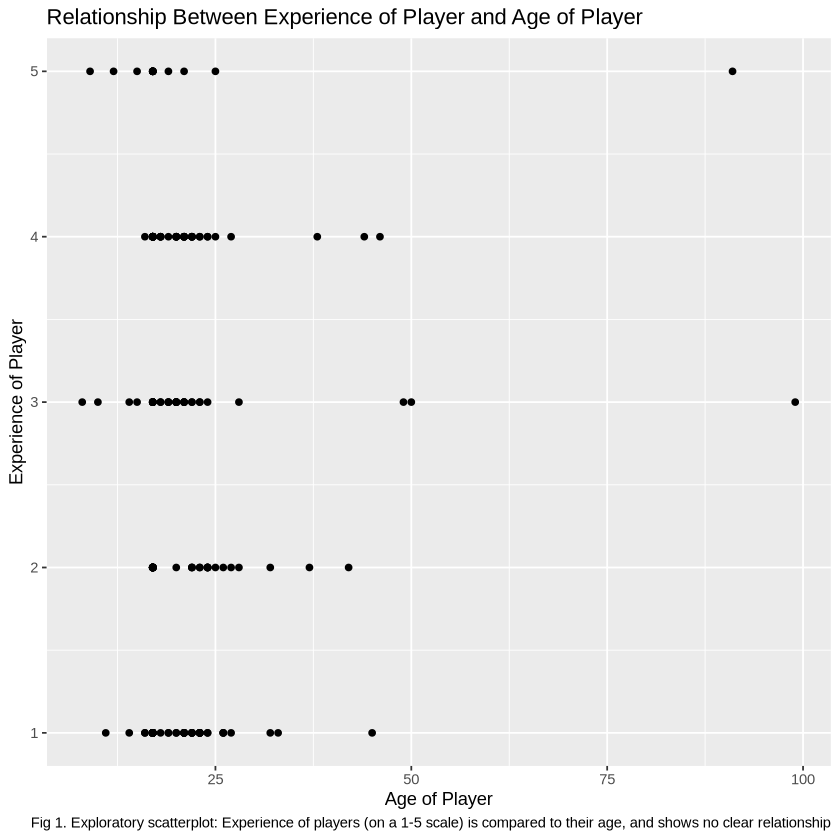

In [3]:
plot_1 <- full_unedited |>
        ggplot(aes(x = age, y = experience)) +
        geom_point() +
        xlab("Age of Player") +
        ylab("Experience of Player") +
        labs(caption = "Fig 1. Exploratory scatterplot: Experience of players (on a 1-5 scale) is compared to their age, and shows no clear relationship") +
        ggtitle("Relationship Between Experience of Player and Age of Player")
plot_1

&nbsp; We then split the data into our training and testing with 70:30 proportions, respectively. This is important because we need to create our model with the training data, independent of the testing data. By doing this, we can later gauge the quality of our model using the testing data which the model has not “seen.” We decided on a 70:30 split after considering the number of observations (196 observations) in the Players Dataset. Our goal was to use what we thought was a sufficient amount of data for training while still keeping a suitable amount for testing the model. As such, we ruled out a 50:50 split because we felt that 196/2 observations were too few to train the model. We also felt that a 60:40 split was too similar in size and thus decided on a 70:30 split, which we felt provided a sufficient amount of data for both training and testing. We will use the same training and testing data frames for both the KNN and linear regression model. We will also use the same 70:30 proportions for our final model later on. In this same step, we set the seed to ensure both that we reproducibly split our data in this step and that all of our following work which requires random selection and/or splitting is reproducible as well.

In [4]:
set.seed(2024)
split <- initial_split(full_unedited, prop = 0.70, strata = played_hours)
training <- training(split)
testing <- testing(split) 
#splitting the data!

We decided to filter outliers out of our training data before proceeding with our model. We made this decision after visualizing our data via a histogram. In the histogram we produced for the training set, the majority of values correlating to our response variable (played_hours) are sub 75 hours of playtime, whereas the outliers have values between 160-260. Because the outliers are so vastly different from the rest of the data, we expect that including these points will significantly decrease the accuracy of our models, especially the linear regression model because the outliers will have too much influence on the line of best fit. Removing the outliers will allow us to produce a much more reliable model with more accurate predictions because the model will better reflect the majority of observations in the dataset.

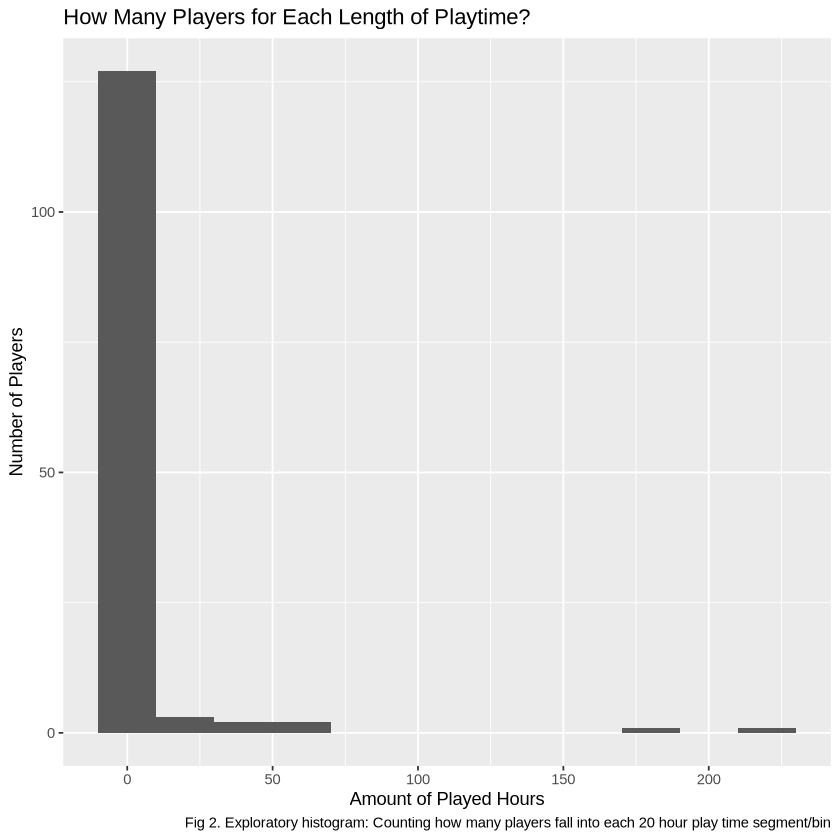

In [5]:
#Removing Outliers
set.seed(2024)
outlier_plot <- training |>
                ggplot(aes(x = played_hours)) +
                geom_histogram(binwidth = 20) +
                xlab("Amount of Played Hours") +
                ylab("Number of Players") + 
                labs(caption = "Fig 2. Exploratory histogram: Counting how many players fall into each 20 hour play time segment/bin") +
                ggtitle("How Many Players for Each Length of Playtime?") 
outlier_plot

experience,played_hours,age
<dbl>,<dbl>,<dbl>
4,0.0,17
1,0.0,17
3,0.0,19
1,0.0,21
1,0.1,17
4,0.0,22


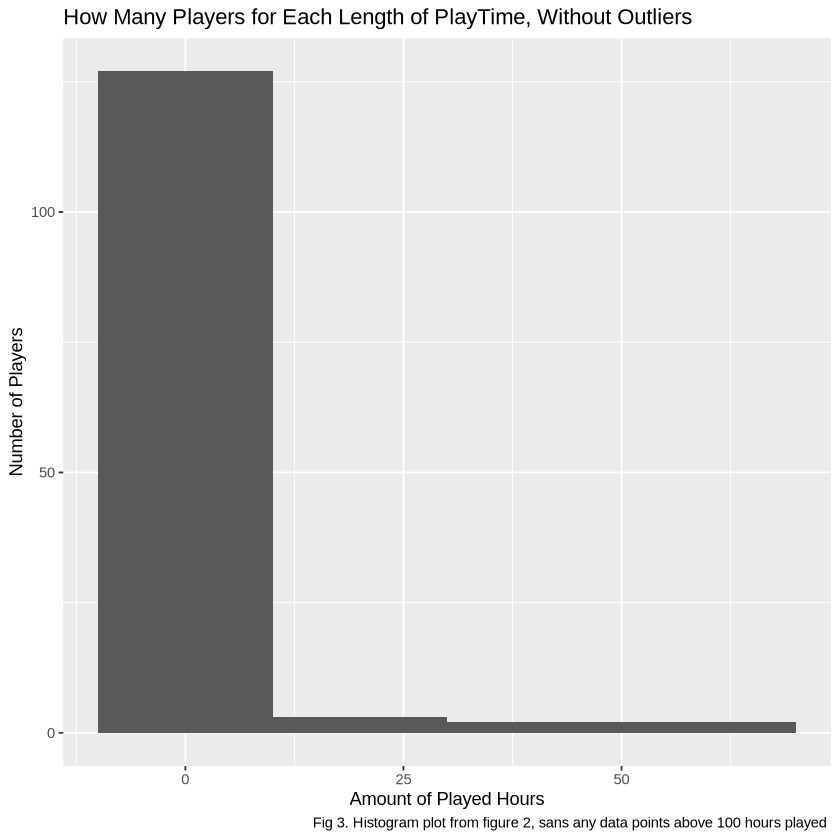

In [6]:
set.seed(2024)

training_final <- training |>
        filter(played_hours < 75)
head(training_final)

without_ot_plot <- training_final |>
                ggplot(aes(x = played_hours)) +
                geom_histogram(binwidth = 20) +
                xlab("Amount of Played Hours") +
                ylab("Number of Players") +
                labs(caption = "Fig 3. Histogram plot from figure 2, sans any data points above 100 hours played ") +
                ggtitle("How Many Players for Each Length of PlayTime, Without Outliers") 
without_ot_plot

&nbsp; For our KNN regression model, we first created a recipe which specified the variable to predict and the variables to be used as predictors a scaled and centered the data. It is important to scale and center the data prior to building the model because it allows the age and experience columns to be similarly weighed when the algorithm calculates distances between data points, which in turn ensures that these variables contribute evenly as predictors for the model. We then added and tuned our model and performed a 5 fold cross-validation from K = 1 to K = 30 neighbours (skipping by 3) on our training data to choose the K-value based on which returned the lowest RMSE. After graphing the K-values and their RMSEs and slicing for the smallest RMSE, we determined that 28 was the best K for our model. Finally, we created another model and workflow, this time with K = 28 as determined in the previous step, and used this model to predict values for our testing data and determine the accuracy of our model. The RMSPE was was 34.6. When considering this value, it is quite large when examining our data set. Many of our observations have played hours below 20 hours, so having a RMSPE of 34.6 may indicate that KNN regression is not a good tool for predicting total hours of play time contributed.  

In [7]:
#knn-classification model 
set.seed(2024)

knn_recipe <- recipe(played_hours ~., data = training_final) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("regression") 

vfold <- vfold_cv(training, v = 5, strata = played_hours) 

wf <- workflow() |>
        add_recipe(knn_recipe) |>
        add_model(knn_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 30, by = 3)) 

knn_results <- wf |>
                tune_grid(resamples = vfold, grid = gridvals) |>
                collect_metrics() |>
                filter(.metric == "rmse") 
head(knn_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,27.42767,5,10.053027,Preprocessor1_Model01
4,rmse,standard,22.23846,5,8.559086,Preprocessor1_Model02
7,rmse,standard,21.55767,5,8.652285,Preprocessor1_Model03
10,rmse,standard,21.41533,5,8.730275,Preprocessor1_Model04
13,rmse,standard,21.63424,5,8.629192,Preprocessor1_Model05
16,rmse,standard,21.27489,5,8.718886,Preprocessor1_Model06


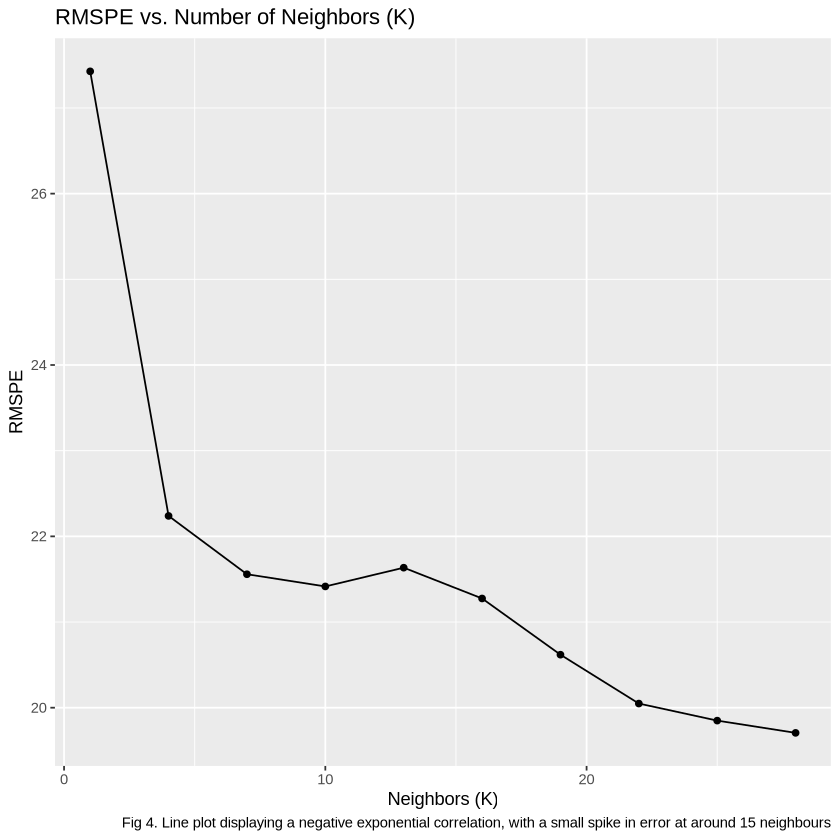

In [8]:
set.seed(2024)
neighbors_plot <- knn_results |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                xlab("Neighbors (K)") +
                ylab("RMSPE") +
                ggtitle("RMSPE vs. Number of Neighbors (K)") +
                labs(caption = "Fig 4. Line plot displaying a negative exponential correlation, with a small spike in error at around 15 neighbours") 
neighbors_plot

In [9]:
set.seed(2024)
knn_best <- knn_results |>
            slice_min(mean, n = 1)
knn_best

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
28,rmse,standard,19.70617,5,9.089821,Preprocessor1_Model10


In [10]:
set.seed(2024)
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 28) |>
            set_engine("kknn") |>
            set_mode("regression") 
best_fit <- workflow() |>
            add_recipe(knn_recipe) |>
            add_model(best_spec) |>
            fit(data = training_final) 
knn_rmspe <- best_fit |>
            predict(testing) |>
            bind_cols(testing) |>
            metrics(truth = played_hours, estimate = .pred) |>
            filter(.metric == "rmse") |>
            select(.estimate)
knn_rmspe

.estimate
<dbl>
34.61918


&nbsp; The process of creating our linear regression model  was essentially the same as that used for the KNN regression model, where we created a recipe, added the model specifications, created a workflow, and trained the model using the training data. We then tested the model using the testing data and found the RMSPE to help determine the accuracy of our model. The RMSPE was was 34.4, slightly below the RMSPE value for our KNN regression model. However, once again, this RMSPE value is very large compared to most values for played_hours in the dataset, indicating that linear regression also may not be a good tool for predicting total hours of play time contributed. 

In [11]:
set.seed(2024)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

lm_recipe <- recipe(played_hours~., data = training_final) 

lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(data = training_final)

lm_rmpse <- lm_fit |>
    predict(testing) |>
    bind_cols(testing) |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter(.metric == "rmse") |>
    select(.estimate)
lm_rmpse

.estimate
<dbl>
34.36562


&nbsp; Finally, we plotted the actual total play hours contributed from the testing data and the predicted total play hours contributed by both our KNN and linear regression model against age and experience to help further analyze the efficiency of our models. 

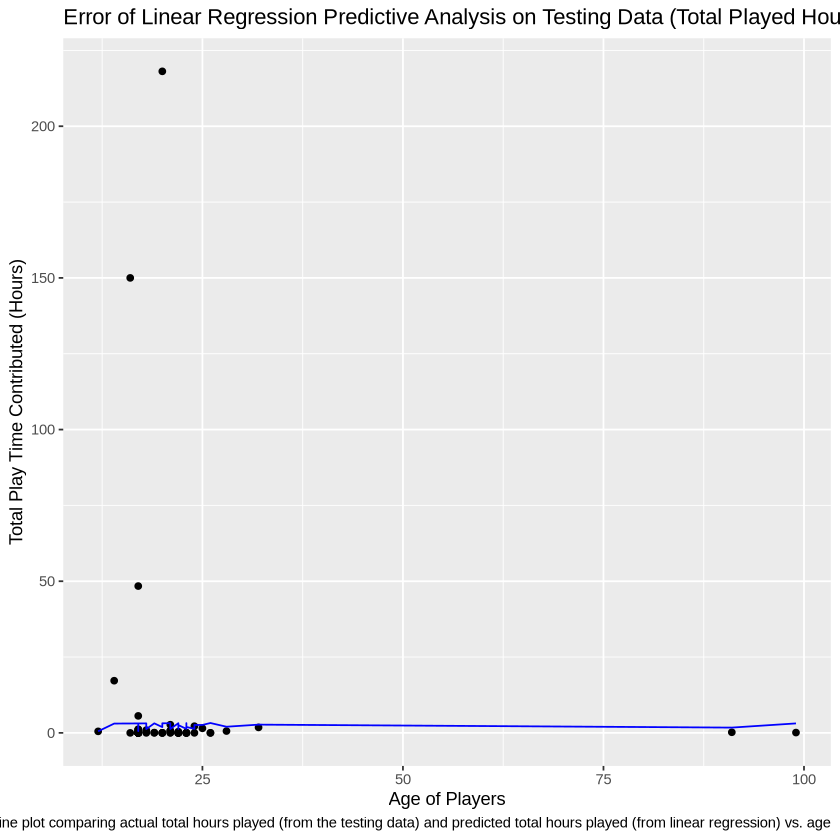

In [14]:
#plotting the linear regression model's + its rmse
predictions <- lm_fit |>
  predict(testing) |>
  bind_cols(testing)

rmse_plot_age <- predictions |>
    ggplot(aes(x = age, y = played_hours)) +
        geom_point() +
        geom_line(aes(x = age, y = .pred), color = "blue") +
        xlab("Age of Players") +
        ylab("Total Play Time Contributed (Hours)") +
        ggtitle("Error of Linear Regression Predictive Analysis on Testing Data (Total Played Hours and Age)") +
        labs(caption = "Fig 5. Line plot comparing actual total hours played (from the testing data) and predicted total hours played (from linear regression) vs. age") 
rmse_plot_age

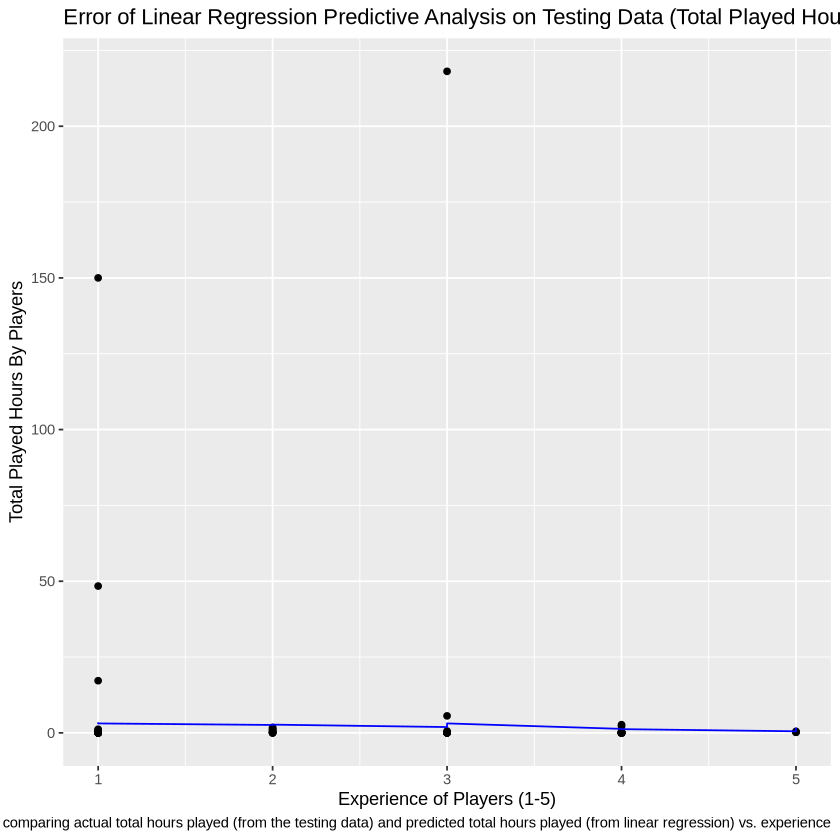

In [15]:
rmse_plot_experience <- predictions |>
    ggplot(aes(x = experience, y = played_hours)) +
        geom_point() +
        geom_line(aes(x = experience, y = .pred), color = "blue") +
        xlab("Experience of Players (1-5)") +
        ylab("Total Played Hours By Players") +
        ggtitle("Error of Linear Regression Predictive Analysis on Testing Data (Total Played Hours and Experience)") +
        labs(caption = "Fig 6. Line plot comparing actual total hours played (from the testing data) and predicted total hours played (from linear regression) vs. experience")
rmse_plot_experience

#### Discussion

#### References